# BLG-407 / Project-1 — Model 2 (Basit CNN – Sıfırdan Eğitim)

**Ad:** Melike
**Soyad:** Çakmakoğlu  
**Okul Numarası:** 221272148  
**GitHub Repo:** https://github.com/mellystark/project-1-ram-classification


## Model 2 – Basit CNN (Sıfırdan Eğitim)

Model 2 kapsamında, **transfer learning kullanılmadan**, tamamen **sıfırdan eğitilen basit bir Convolutional Neural Network (CNN)** mimarisi kullanılmıştır. Bu modelin temel amacı, hazır ve ön-eğitimli mimarilerden bağımsız olarak, veri setine dayalı öğrenmenin sınıflandırma performansını gözlemlemektir.

Kullanılan CNN mimarisi, literatürde ve ders kapsamında sıkça referans verilen **CIFAR-10 örneklerindeki basit CNN yaklaşımına benzer** şekilde tasarlanmıştır. Bu yaklaşım; ardışık **Conv2D + ReLU** katmanları, **MaxPooling** ile boyut azaltma ve **Dense** katmanlar ile sınıflandırma adımlarını içermektedir. Böylece model karmaşıklığı kontrollü tutulmuş ve temel konvolüsyonel öğrenme davranışı analiz edilebilir hale getirilmiştir.

Model 2, bu yönüyle **Model 3’te yapılacak geliştirmeler için bir “baseline (referans) model”** olarak konumlandırılmıştır. Model 3’te uygulanacak hiperparametre değişiklikleri ve veri artırma (augmentation) tekniklerinin etkisi, doğrudan Model 2 sonuçlarıyla karşılaştırılacaktır.


## Google Drive Bağlama

Google Drive’ı Colab ortamına bağlayarak Drive’daki dosyalara doğrudan erişim sağlar.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Görüntü Dataset Yükleme ve Ön İşleme

Eğitim/Doğrulama/Test klasörlerinden görüntüleri yükler, yeniden boyutlandırır, normalize eder (0–1) ve cache + prefetch ile eğitim için optimize edilmiş tf.data pipeline’ı oluşturur.

In [2]:
import tensorflow as tf
from pathlib import Path

# SABİT KABULLER
DATASET_DIR = "/content/drive/MyDrive/Colab Notebooks/Makine_Ogrenmesi/project-1-ram"
CLASSES = ["laptop_ram", "desktop_ram"]
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

# split_root (varsa kullan, yoksa üret)
if "split_root" in globals():
    split_root = Path(split_root)
else:
    split_root = Path(DATASET_DIR).parent / (Path(DATASET_DIR).name + "_split_70_15_15")

train_dir = split_root / "train"
val_dir   = split_root / "val"
test_dir  = split_root / "test"

# Dataset yükleme
tf.keras.utils.set_random_seed(SEED)

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    class_names=CLASSES,
    image_size=IMG_SIZE,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels="inferred",
    label_mode="int",
    class_names=CLASSES,
    image_size=IMG_SIZE,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="int",
    class_names=CLASSES,
    image_size=IMG_SIZE,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Normalize (0–1)
rescale = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (rescale(x), y), num_parallel_calls=AUTOTUNE)
val_ds   = val_ds.map(lambda x, y: (rescale(x), y), num_parallel_calls=AUTOTUNE)
test_ds  = test_ds.map(lambda x, y: (rescale(x), y), num_parallel_calls=AUTOTUNE)

# cache + prefetch
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)

# Doğrulamalar
print("train_ds.class_names:", train_ds.class_names if hasattr(train_ds, "class_names") else CLASSES)

images, labels = next(iter(train_ds))
print("Batch image shape:", images.shape)   # (32, 128, 128, 3)
print("Batch label shape:", labels.shape)   # (32,)
print("Pixel min/max:", float(tf.reduce_min(images)), float(tf.reduce_max(images)))


Found 100 files belonging to 2 classes.
Found 22 files belonging to 2 classes.
Found 20 files belonging to 2 classes.
train_ds.class_names: ['laptop_ram', 'desktop_ram']
Batch image shape: (32, 128, 128, 3)
Batch label shape: (32,)
Pixel min/max: 0.0 1.0


## Model 2 Hiperparametre Tanımları

Model 2 için giriş boyutu, sınıf sayısı, batch size, epoch, öğrenme oranı ve dropout gibi temel eğitim hiperparametrelerini tanımlar.

In [7]:
# ===============================
# MODEL 2 HYPERPARAMETERS
# ===============================
INPUT_SHAPE = (128, 128, 3)
NUM_CLASSES = 2

BATCH_SIZE = 32
EPOCHS = 25
LEARNING_RATE = 1e-3
DROPOUT_RATE = 0.5


## Model 2 – Sıfırdan CNN Mimarisi

Görüntüleri doğrudan öğrenmek için sıfırdan oluşturulmuş, ardışık konvolüsyon ve pooling katmanlarından oluşan temel bir CNN sınıflandırma modeli tanımlar.

In [9]:
from tensorflow import keras
from tensorflow.keras import layers

model2 = keras.Sequential(
    [
        keras.Input(shape=INPUT_SHAPE, name="input_image"),

        # Block 1
        layers.Conv2D(32, (3, 3), padding="same", activation="relu"),
        layers.Conv2D(32, (3, 3), padding="same", activation="relu"),
        layers.MaxPooling2D((2, 2)),

        # Block 2
        layers.Conv2D(64, (3, 3), padding="same", activation="relu"),
        layers.Conv2D(64, (3, 3), padding="same", activation="relu"),
        layers.MaxPooling2D((2, 2)),

        # Block 3
        layers.Conv2D(128, (3, 3), padding="same", activation="relu"),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(DROPOUT_RATE),
        layers.Dense(NUM_CLASSES, activation="softmax"),
    ],
    name="Model2_BasicCNN_FromScratch"
)


In [10]:
model2.summary()


Model: "Model2_BasicCNN_FromScratch"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,334,114 (16.53 MB)

 Trainable params: 4,334,114 (16.53 MB)

 Non-trainable params: 0 (0.00 B)

Konvolüsyonel sinir ağı (CNN) modeli derlenir; Adam optimizasyonu ve sparse_categorical_crossentropy kaybı kullanılarak iki sınıflı görüntü sınıflandırma için eğitime hazır hale getirilir.

In [12]:
model2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


## Sıfırdan CNN Eğitimi ve Değerlendirme

Temel bir CNN modeli eğitilir, doğrulama performansı Early Stopping ile izlenir; eğitim–doğrulama doğruluk/kayıp grafikleri çizilir ve model test verisi üzerinde değerlendirilir.

Epoch 1/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5000 - loss: 0.7498 - val_accuracy: 0.5000 - val_loss: 0.6988
Epoch 2/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.4112 - loss: 0.7225 - val_accuracy: 0.5000 - val_loss: 0.6914
Epoch 3/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.5592 - loss: 0.6891 - val_accuracy: 0.5000 - val_loss: 0.6882
Epoch 4/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.5659 - loss: 0.6893 - val_accuracy: 0.5909 - val_loss: 0.6653
Epoch 5/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.5457 - loss: 0.6638 - val_accuracy: 0.8182 - val_loss: 0.5250
Epoch 6/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.8803 - loss: 0.4457 - val_accuracy: 1.0000 - val_loss: 0.1211
Epoch 7/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.8926 - loss: 0.4039 - val_accuracy: 0.7727 - val_loss: 0.3067
Epoch 8/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8984 - loss: 0.2735 - val_accuracy: 0.8182 - val_loss: 0.2881
Epoch 9/25

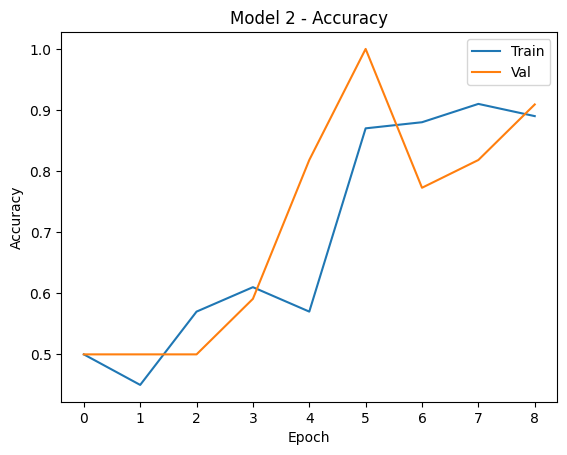

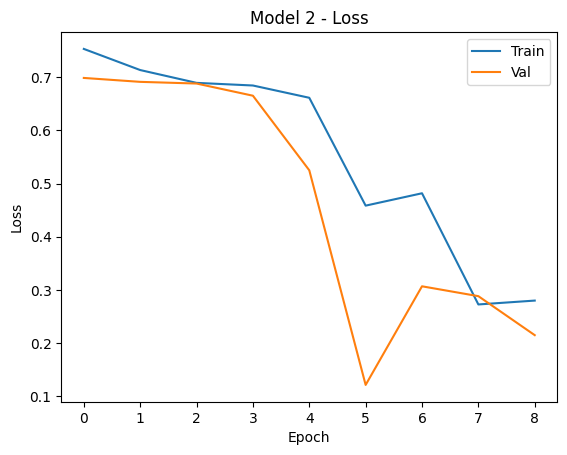

Model 2 Test Accuracy: 0.9000


In [13]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

history2 = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop],
    verbose=1
)

# Grafikler
hist = history2.history

plt.figure()
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.title("Model 2 - Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Val"])
plt.show()

plt.figure()
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title("Model 2 - Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

# Test
test_loss, test_acc = model2.evaluate(test_ds, verbose=0)
print(f"Model 2 Test Accuracy: {test_acc:.4f}")


## Model 2 Sonuç ve Değerlendirme

Model 2 kapsamında elde edilen **test doğruluğu**, bu proje için bir **referans (baseline) performans değeri** olarak kabul edilmiştir. Bu sonuçlar, sıfırdan eğitilen basit bir CNN mimarisinin, laptop_ram ve desktop_ram sınıfları arasında belirli bir ayrım yapabildiğini göstermektedir.

Bu modelde **hiperparametre optimizasyonu veya veri artırma (augmentation) bilinçli olarak uygulanmamıştır**. Bu tercih, Model 2’nin karmaşıklığını sınırlı tutmak ve yapılacak iyileştirmelerin etkisini daha net gözlemleyebilmek amacıyla yapılmıştır.

Bir sonraki aşama olan **Model 3’te**, bu baseline model temel alınarak hiperparametre ayarlamaları ve veri artırma teknikleri uygulanacak; böylece Model 2’ye kıyasla performans artışı hedeflenecektir.
